- https://github.com/facebookresearch/WSL-Images/blob/master/hubconf.py
- https://www.kaggle.com/zhangyang/bldcv0719-2

# params

In [1]:
PRFX = 'CV0719-1'
p_o = f'../output/{PRFX}'
from pathlib import Path
Path(p_o).mkdir(exist_ok=True)

SEED = 111

BS = 16
SZ = 448
FP16 = True
DO_UPSAMPLE = False

In [2]:
# get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

from fastai.vision import *
params_tfms = dict(     
    max_lighting=0.1,
    max_warp=0,
    max_rotate=0,
    max_zoom=0,)

resize_method = ResizeMethod.PAD
padding_mode = 'zeros'

# setup

In [3]:
from fastai.vision import *
from torchvision.models.resnet import ResNet, Bottleneck
import cv2

import random 
import numpy as np
import torch
import os


def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

In [4]:
def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, _ = crop_margin(image)

    image = center_crop(image)

    image = cv2.resize(image, (640, 480))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = open_yz

# prep

In [5]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [6]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [7]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [8]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']
display(df.shape)
df.target.value_counts()

(3662, 2)

0    1805
2     999
1     370
4     295
3     193
Name: target, dtype: int64

https://www.kaggle.com/chanhu/eye-inference-num-class-1-ver3 LB 0.77

    [0.57, 1.37, 2.57, 3.57]
    2    1226
    0     326
    3     200
    1     152
    4      24

In [9]:
if DO_UPSAMPLE:
    print('Doing upsample!')
    set_torch_seed()
    df2=df[df.target==2].copy()
    df3=df[df.target==3].sample(frac=1.5, replace=True).copy()
    df = pd.concat([df, df2, df3]).reset_index()
    df.target.value_counts()

In [10]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.10), replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

In [11]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz, 
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 7.52 s, sys: 407 ms, total: 7.93 s
Wall time: 5.47 s


CPU times: user 4.46 s, sys: 1.9 s, total: 6.36 s
Wall time: 13.1 s


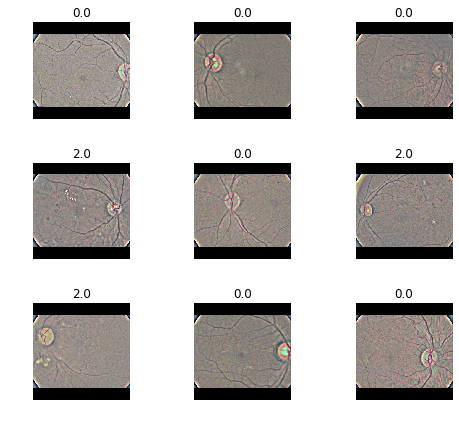

In [12]:
%%time
data.show_batch(rows=3, figsize=(7,6))

# model

In [13]:
def _resnext(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    model.load_state_dict(torch.load('../input/resnext-pretrained-models/ig_resnext101_32x16-c6f796b0.pth'))
    return model

def resnext101_32x16d_wsl(progress=True, **kwargs):
    """Constructs a ResNeXt-101 32x16 model pre-trained on weakly-supervised data
    and finetuned on ImageNet from Figure 5 in
    `"Exploring the Limits of Weakly Supervised Pretraining" <https://arxiv.org/abs/1805.00932>`_
    Args:
        progress (bool): If True, displays a progress bar of the download to stderr.
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 16
    return _resnext('resnext101_32x16d', Bottleneck, [3, 4, 23, 3], True, progress, **kwargs)

model = resnext101_32x16d_wsl()

In [14]:
# https://www.kaggle.com/abhishek/pytorch-inference-kernel-lazy-tta
# model.avg_pool = nn.AdaptiveAvgPool2d(1)
# model.last_linear = nn.Sequential(
#                           nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                           nn.Dropout(p=0.25),
#                           nn.Linear(in_features=2048, out_features=2048, bias=True),
#                           nn.ReLU(),
#                           nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                           nn.Dropout(p=0.5),
#                           nn.Linear(in_features=2048, out_features=1, bias=True),
#                          )

#  https://www.kaggle.com/zhangyang/blddevfastailayergroups-0716-1/
# Sequential(
#   (0): AdaptiveConcatPool2d(
#     (ap): AdaptiveAvgPool2d(output_size=1)
#     (mp): AdaptiveMaxPool2d(output_size=1)
#   )
#   (1): Flatten()
#   (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (3): Dropout(p=0.25)
#   (4): Linear(in_features=4096, out_features=512, bias=True)
#   (5): ReLU(inplace)
#   (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (7): Dropout(p=0.5)
#   (8): Linear(in_features=512, out_features=2, bias=True)
# )
model.avgpool = AdaptiveConcatPool2d(1)
model.fc = nn.Sequential(Flatten(),
              nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.Dropout(p=0.25),
              nn.Linear(in_features=4096, out_features=512, bias=True),
              nn.ReLU(),
              nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.Dropout(p=0.5),
              nn.Linear(in_features=512, out_features=1, bias=True))

## layer_groups

In [15]:
layer_groups=[nn.Sequential(model.conv1, 
                            model.bn1, 
                            model.relu, 
                            model.maxpool,
                            model.layer1,
                            model.layer2,),
              nn.Sequential(model.layer3,
                            model.layer4),
              nn.Sequential(model.avgpool, 
                            model.fc)]

In [16]:
device = torch.device("cuda")
model = model.to(device)
learn = Learner(data, model,
                layer_groups=layer_groups,
                path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

# train

In [17]:
learn.freeze()

In [18]:
%%time
learn.lr_find(start_lr=1e-5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 1min 51s, sys: 1min 1s, total: 2min 52s
Wall time: 3min 2s


In [19]:
!nvidia-smi

Sat Jul 20 02:15:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    47W / 300W |  15739MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Min numerical gradient: 2.09E-04
Min loss divided by 10: 6.92E-03


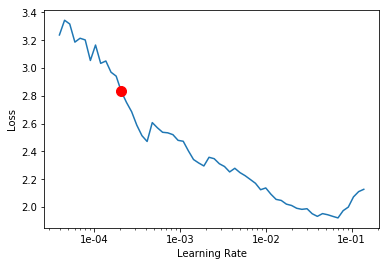

In [20]:
learn.recorder.plot(suggestion=True)

In [21]:
set_torch_seed()
learn.fit_one_cycle(20, max_lr=2e-3, callbacks=[SaveModelCallback(learn, name='bestmodel_frozen')])

epoch,train_loss,valid_loss,time
0,1.658624,1.200613,08:20
1,0.905048,0.577110,08:21
2,0.750828,0.513469,08:20
3,0.649906,0.505817,08:22
4,0.590822,0.540605,08:22
5,0.630056,0.514292,08:20
6,0.597816,0.525626,08:21
7,0.607100,0.499333,08:21
8,0.612997,0.484726,08:23
9,0.535676,0.454868,08:25


Better model found at epoch 0 with valid_loss value: 1.2006129026412964.
Better model found at epoch 1 with valid_loss value: 0.5771101713180542.
Better model found at epoch 2 with valid_loss value: 0.5134690403938293.
Better model found at epoch 3 with valid_loss value: 0.5058172941207886.
Better model found at epoch 7 with valid_loss value: 0.499332994222641.
Better model found at epoch 8 with valid_loss value: 0.48472627997398376.
Better model found at epoch 9 with valid_loss value: 0.4548676609992981.
Better model found at epoch 10 with valid_loss value: 0.44034847617149353.
Better model found at epoch 12 with valid_loss value: 0.43768730759620667.
Better model found at epoch 15 with valid_loss value: 0.41554510593414307.


In [22]:
# learn.unfreeze()

In [23]:
# %%time
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.75 GiB total capacity; 14.65 GiB already allocated; 14.88 MiB free; 107.64 MiB cached)

In [ ]:
# set_torch_seed()
# learn.fit_one_cycle(10, max_lr=slice(1e-8, 1e-6), callbacks=[SaveModelCallback(learn, name='bestmodel_finetune')])

In [ ]:
# learn.recorder.plot_losses()

In [18]:
!nvidia-smi

Sat Jul 20 11:01:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    40W / 300W |   1793MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# TTTA

In [19]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

# validate and thresholding

In [21]:
# learn = learn.load('bestmodel_finetune')

In [22]:
learn = learn.load('bestmodel_frozen')

In [23]:
learn = learn.to_fp32()

In [24]:
%%time
set_torch_seed()
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 6.72 s, sys: 3.26 s, total: 9.98 s
Wall time: 23.1 s


In [25]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [26]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [27]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [28]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [29]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [30]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [31]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 3.48 s, sys: 0 ns, total: 3.48 s
Wall time: 3.47 s


In [32]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 407 ms, sys: 204 µs, total: 408 ms
Wall time: 406 ms


In [33]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.5000660342883434,
  2.150983961351656,
  2.8820660342883433],
 'abhishek': array([0.527895, 1.436349, 2.421282, 3.69009 ])}

In [34]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [35]:
optnm2qwk

{'simple': 0.8654849243034647,
 'hocop1': 0.8726807188709697,
 'abhishek': 0.8782745297838916}

In [36]:
Counter(y_val).most_common()

[(0.0, 173), (2.0, 110), (1.0, 31), (4.0, 28), (3.0, 24)]

In [37]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [38]:
preds_val_grd.mean()

1.2049180327868851

In [39]:
Counter(preds_val_grd).most_common()

[(0.0, 158), (2.0, 103), (3.0, 47), (1.0, 46), (4.0, 12)]

In [40]:
list(zip(preds_val_grd, y_val))[:10]

[(2.0, 1.0),
 (3.0, 2.0),
 (2.0, 2.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (3.0, 4.0),
 (0.0, 0.0),
 (4.0, 4.0)]

In [41]:
(preds_val_grd== y_val.squeeze()).mean()

0.6885245901639344

In [42]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [43]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_val_grd = bucket(preds_val, coef)
    display(pd.Series(preds_val_grd.squeeze().astype(int)).value_counts())

simple 0.8654849243034647 [0.5, 1.5, 2.5, 3.5]


0    158
2    103
3     47
1     46
4     12
dtype: int64

hocop1 0.8726807188709697 [1.0000660342883434, 1.5000660342883434, 2.150983961351656, 2.8820660342883433]


0    185
2     76
3     56
4     30
1     19
dtype: int64

abhishek 0.8782745297838916 [0.527895 1.436349 2.421282 3.69009 ]


0    162
2    103
3     57
1     37
4      7
dtype: int64

# testing

In [44]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [45]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

CPU times: user 568 ms, sys: 477 ms, total: 1.05 s
Wall time: 6.22 s


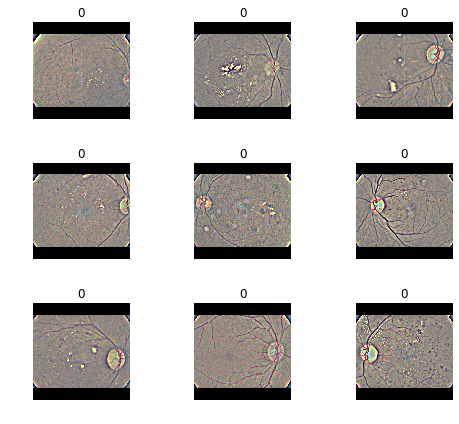

In [46]:
%%time
data.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Test)

In [47]:
%%time
set_torch_seed()
preds_tst, _ = learn.TTA(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

CPU times: user 3min 28s, sys: 1min 32s, total: 5min 1s
Wall time: 5min 41s


In [48]:
np.save(f'{p_o}/preds_tst.npy', preds_tst)

In [49]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [50]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_tst_grd = bucket(preds_tst, coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())

simple 0.8654849243034647 [0.5, 1.5, 2.5, 3.5]


1    797
2    746
0    204
3    162
4     19
dtype: int64

hocop1 0.8726807188709697 [1.0000660342883434, 1.5000660342883434, 2.150983961351656, 2.8820660342883433]


2    547
0    518
1    483
3    314
4     66
dtype: int64

abhishek 0.8782745297838916 [0.527895 1.436349 2.421282 3.69009 ]


2    770
1    729
0    212
3    202
4     15
dtype: int64

In [51]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)
pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


1    797
2    746
0    204
3    162
4     19
dtype: int64

## submit

In [52]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,1


In [53]:
subm.diagnosis.value_counts()

1    797
2    746
0    204
3    162
4     19
Name: diagnosis, dtype: int64

In [54]:
subm.to_csv(f"{p_o}/submission.csv", index=False)